In [1]:
# Data reading
# ==============================================================================
import numpy as np
import pandas as pd
import xarray as xr
import glob

# Graphics 
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Preprocessing and modeling
# ==============================================================================
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

# Metrics 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import time
from sklearn.metrics import mean_absolute_percentage_error
# Warnings configuration 
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Path of your data
path = 'D:/Documentos/Maestria/DATOS ERA5/ERA5/'
mlg = 'D:/Documentos/Maestria/MLG/'
save_imgs = mlg+'IMGS/'

In [3]:
# Read your data
data = xr.open_dataset(path+'DATASET_ERA5.nc')
data_copy = data

In [4]:
dates_test = slice('2020-01-01','2020-12-31')
data = data.sel(time=dates_test)

la optimizacion se hara para el horizonte de 24 horas

In [5]:
hzn = 24
Y = data.mn2t[hzn:]
X = data#.drop(['mn2t'])
X = X.sel(time=data.time[:-hzn]) 
scaler = StandardScaler()

In [6]:
def prepro(X, Y, i, j, t_sz):
    lat = X.latitude[i]
    lon = X.longitude[j]
    
    x_sub = X.sel(latitude = lat, longitude = lon)
    x_sub = x_sub.to_array()
    # - Swapaxes to have a array with shape (n_samples, n_features)
    x_sub = np.swapaxes(x_sub, 0,1)
    y_sub = Y.sel(latitude = lat, longitude = lon).values
    # - Standarization of the data
    x_sub_s = scaler.fit_transform(x_sub)
    y_sub_s = scaler.fit_transform(y_sub.reshape(-1,1))
    y_sub_s = y_sub_s.reshape(y_sub.shape)
            
    #==================== Split the data ==================== 
    # - In this case we avoid use shuffle because the data order is important
    x_train, x_test, y_train, y_test = train_test_split(
        x_sub_s, y_sub_s, test_size=t_sz, shuffle = False)
    
    return x_train, x_test, y_train, y_test

# Build a function to integrate space by a choosen statistic 
def dt_to_df(dt, stat):
    if stat=='mean':
        stat_arr = np.nanmean(dt, axis=(1,2))
    elif stat=='median':
        stat_arr = np.nanmedian(dt, axis=(1,2))
    elif stat=='min':
        stat_arr = np.nanmin(dt, axis=(1,2))
    elif stat=='sum':
        stat_arr = np.sum(dt, axis=(1,2))
    else:
        print('stat no valid')
        
    df = pd.DataFrame(stat_arr.transpose())
    
    return df



# Linear model optimization 

In [16]:
# - Model instantiation
lmr = linear_model.Ridge(fit_intercept=False)
lmr_op = linear_model.Ridge(alpha=10, 
                            fit_intercept=False, 
                            solver= 'sag')

In [69]:
param_lmr = dict(fit_intercept=[True,False], 
                 solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
                 alpha=[0.001,  0.01, 0.1, 1, 5, 10])

search = GridSearchCV(lmr, param_lmr, cv=5).fit(x_train, y_train)
print(search.best_params_)  
print(search.best_score_)

{'alpha': 10, 'fit_intercept': False, 'solver': 'sag'}
0.3923757772525521


In [13]:
x_trlmr, x_telmr, y_trlmr, y_telmr = prepro(X, Y, 3, 23, 0.33)

In [15]:
st_lmr = time.time()
lmr.fit(x_trlmr,y_trlmr)
y_lmr = lmr.predict(x_telmr)
            
lmr_score = lmr.score(x_trlmr, y_trlmr)
lmr_r2 = r2_score(y_telmr, y_lmr)
lmr_mse = mean_squared_error(y_telmr, y_lmr, squared=False)

ed_lmr = time.time()
tt_lmr = ed_lmr-st_lmr

In [16]:
st_lmr_op = time.time()
lmr_op.fit(x_trlmr,y_trlmr)
y_lmr_op = lmr_op.predict(x_telmr)
            
lmr_op_score = lmr_op.score(x_trlmr, y_trlmr)
lmr_op_r2 = r2_score(y_telmr, y_lmr_op)
lmr_op_mse = mean_squared_error(y_telmr, y_lmr_op, squared=False)

ed_lmr_op = time.time()
tt_lmr_op = ed_lmr_op-st_lmr_op

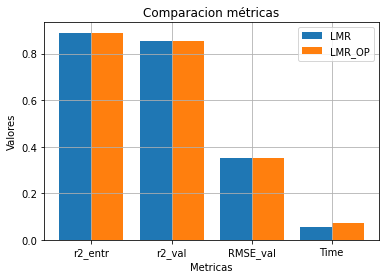

In [18]:
X = ['r2_entr','r2_val','RMSE_val','Time']
Ylmr = [lmr_score, lmr_r2, lmr_mse, tt_lmr]
Zlmr_op = [lmr_op_score, lmr_op_r2, lmr_op_mse, tt_lmr_op]
  
X_axis = np.arange(len(X))
  
plt.figure()
plt.bar(X_axis - 0.2, Ylmr, 0.4, label = 'LMR')
plt.bar(X_axis + 0.2, Zlmr_op, 0.4, label = 'LMR_OP')
  
plt.xticks(X_axis, X)
plt.xlabel("Metricas")
plt.ylabel("Valores")
plt.title("Comparacion métricas")
plt.grid(':')
plt.legend()
plt.savefig(save_imgs+'LMR_metrics_comp.png', dpi=300)

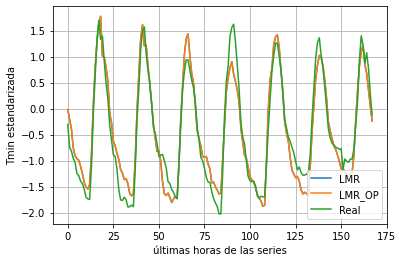

In [22]:
plt.plot(y_lmr[-168:], label='LMR')
plt.plot(y_lmr_op[-168:], label='LMR_OP')
plt.plot(y_telmr[-168:], label='Real')
plt.legend()
plt.xlabel('últimas horas de las series')
plt.ylabel('Tmin estandarizada')
plt.grid(':')
plt.savefig(save_imgs+'LMR_series_comp.png', dpi=300)

# MLP optimization

In [25]:
x_trop, x_teop, y_trop, y_teop = prepro(X, Y, 3, 23, 0.33)

In [ ]:
param_mlp = dict(hidden_layer_sizes=[(12,6),(6,6),(24,12),(6,3)], 
                 activation=['relu', 'tanh', 'logistic'],
                 solver = ['lbfgs','sgd', 'adam'],
                 learning_rate=['invscaling', 'adaptive'])

search = GridSearchCV(mlp, param_mlp, cv=5).fit(x_train, y_train)
print(search.best_params_)  
print(search.best_score_)

In [9]:
mlp = MLPRegressor((12,6), early_stopping=True)
mlp_op = MLPRegressor((12,6),
                      activation= 'logistic', 
                      solver='lbfgs', 
                      early_stopping=True)

In [27]:
mlp.fit(x_trop, y_trop)
mlp_op.fit(x_trop, y_trop)

MLPRegressor(activation='logistic', early_stopping=True,
             hidden_layer_sizes=(12, 6), solver='lbfgs')

In [30]:
st_mlp = time.time()
y_mlp = mlp.predict(x_teop)
mlp_score = mlp.score(x_trop, y_trop)
mlp_r2 = r2_score(y_teop, y_mlp)
mlp_mse = mean_squared_error(y_teop, y_mlp, squared=False)
ed_mlp = time.time()
tt_mlp = ed_mlp-st_mlp

In [31]:
st_mlp_op = time.time()
y_mlp_op = mlp.predict(x_teop)
mlp_op_score = mlp.score(x_trop, y_trop)
mlp_op_r2 = r2_score(y_teop, y_mlp_op)
mlp_op_mse = mean_squared_error(y_teop, y_mlp_op, squared=False)
ed_mlp_op = time.time()
tt_mlp_op = ed_mlp_op-st_mlp_op

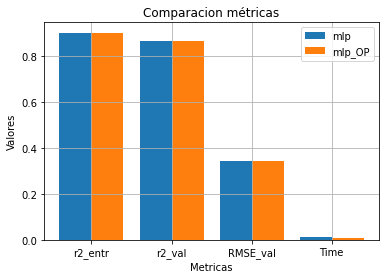

In [33]:
X = ['r2_entr','r2_val','RMSE_val','Time']
Ymlp = [mlp_score, mlp_r2, mlp_mse, tt_mlp]
Zmlp_op = [mlp_op_score, mlp_op_r2, mlp_op_mse, tt_mlp_op]
  
X_axis = np.arange(len(X))
  
plt.figure()
plt.bar(X_axis - 0.2, Ymlp, 0.4, label = 'mlp')
plt.bar(X_axis + 0.2, Zmlp_op, 0.4, label = 'mlp_OP')
  
plt.xticks(X_axis, X)
plt.xlabel("Metricas")
plt.ylabel("Valores")
plt.title("Comparacion métricas")
plt.grid(':')
plt.legend()
plt.savefig(save_imgs+'MLP_metrics_comp.png', dpi=300)

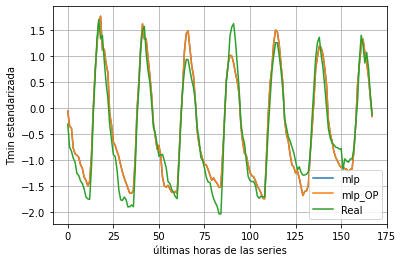

In [35]:
plt.plot(y_mlp[-168:], label='mlp')
plt.plot(y_mlp_op[-168:], label='mlp_OP')
plt.plot(y_teop[-168:], label='Real')
plt.legend()
plt.xlabel('últimas horas de las series')
plt.ylabel('Tmin estandarizada')
plt.grid(':')
plt.savefig(save_imgs+'MLP_series_comp.png', dpi=300)